## Installation notes: 

This Notebook uses the R kernel. If your Jupyter installation does not have an R kernel installed, follow the instructions [here](https://www.continuum.io/blog/developer/jupyter-and-conda-r). If after installing, your R kernel keeps dying, see [this issue](https://github.com/ContinuumIO/anaconda-issues/issues/1133#issuecomment-251249756). What finally worked for me was to open my Renviron file and comment out all lines starting with "R_LIBS_USER=". 


Alternative installation instructions can be found [here](http://irkernel.github.io/installation).

## To Do:

* add code from `parse_composites.R` for creating `Q000001.csv` etc.  
* clean up section "Map sections to documents"  
* start new notebook for analyzing section order?

# Part 1: Analysis based on order of entries within a section

## Defining sections

The first step in analyzing order of entries within a section must be defining what constitutes a section. We've discussed three methods for defining sections. 

**1) Expert definition.**  
**2) Automated based on composite text (eg. Q000039).**  
**3) Automated based on entry proximity.** 

These methods are described more below:


**1) Expert definition.**  
Expert manually determines section boundaries based on knowledge of text type. This approach is the most sound, but does not scale. If we relied on this method, we would not be able to use our workflow with other collections of lexical lists without a time-intensive manual step. This method will be set aside for now. We may, however, want to leave users (assuming there ever are any) the option to read in and use their own section definitions for downstream analyses.  

**2) Automated based on composite text.**  
A composite text is read in and breakpoints in the text are determined based on fuzzy matching of similar words (either in base or lemma). Entries between those breakpoints are assumed to belong to the same section. This method would need to be tested and perhaps supervised to ensure that nonsense sections (a collection of words that don't really belong to any section) aren't grouped together. It may also miss sections that are based not on similarity of words (e.g. "palm") but similarity of object type or use (e.g. "bowl", "spoon", "cup"), unless that section is between two sections that are picked up by this method.  

Based on the following (artificial) Q text, this method should lead to three sections. Lines 1-4 (related to palm), lines 5-8 (related to poplar), and lines 9-14 (related to tree). 

*1) ŋešnimbar[palm]N*  
*2) ŋešnimbar[palm]N sux:suhuš[offshoot]N*  
*3) deg[collect]V/t sux:ŋešnimbar[palm]N*  
*4) niŋkiluh[broom]N sux:ŋešnimbar[palm]N*  
*5) asal[poplar]N*  
*6) asal[poplar]N sux:kur[mountain]N*  
*7) asal[poplar]N sux:dug[good]V/i*  
*8) numun[seed]N sux:asal[poplar]N*  
*9) ilur[tree]N*  
*10) ad[bush]N*  
*11) kišig[acacia]N*  
*12) kišighar[tree]N*  
*13) samazum[tree]N*  
*14) peškal[tree]N*  

**3) Automated based on entry proximity**  
Lines that always apear within a certain (small) distance from each other could be considered to be part of the same section. Sections are defined based on entire corpus, not just a composite text. (eg. moving window, ~6-8 lines, middle in target)

## Method 2) Automated based on composite text.

Our strategy for implementing this method is the following:  
1) First, calculate the degree of similarity between any two adjacent entries in the source/composite document. This similarity can take two independent forms:
- shared character strings in the Sumerian (citation form) or the English (guideword)
- shared entire words (citation forms and/or guidewords)  

2) Next, determine appropriate cutoff values for similarity that distinguish between sections.    
3) Next, automatically assign a name to each section for ease of reference.  
4) Finally, output a file containing the entries present in each section. 

We can then use these section definitions to analyze similarities and differences between texts.

### R Package list

The following R packages are used in this notebook.

* ggplot2()  
* ggdendro()  
* Rlibstree() (a Bioconductor package)   
* reshape()  
* scales()

Use the function `.libPaths()` to find the path where anaconda stores your packages. You can then use this path as a variable to instruct R where to store and where to find packages. Change the variable `lib.dir` accordingly. 

In [1]:
.libPaths()

[1] "/anaconda/lib/R/library"

In [1]:
lib.dir = '/anaconda/lib/R/library'

library(ggplot2, lib.loc = lib.dir)
library(ggdendro, lib.loc = lib.dir)
library(reshape, lib.loc = lib.dir)
library(scales, lib.loc = lib.dir)

Warning message:
“package ‘ggplot2’ was built under R version 3.4.0”

### Installing Rlibstree and Bioconductor

To calculate the longest shared substring between two entries, we are using the `Rlibstree` package from Bioconductor. The following cells installs Bioconductor and the package we want, repectively, and only need to be run once. You will get a prompt box with no text. This is for updating the packages listed in the warning box. I suggest entering "n" for no, as the notebook seems to have a problem with updating all the listed packages and times out.

In [2]:
#source("http://bioconductor.org/biocLite.R")
#biocLite("BiocInstaller")
#library(BiocInstaller)
#biocLite("Rlibstree")

library("Rlibstree")

This method for defining sections relies in part on looking for words shared between entries. These shared words can be citation forms (Sumerian) and/or guidewords (English). The functions below enable us to extract guidewords and citation forms from entries.

In [3]:
get_guidewords = function(line) {
  # extract all guidewords for an entry into character vector
  line = unlist(strsplit(line, "_"))
  line = gsub(".*\\[", "", line)
  line = gsub("\\].*", "", line)
  line = gsub("~", "", line)
  guidewords = line
  guidewords = guidewords[which(guidewords != "na")]
  guidewords
}

get_citation_forms = function(line) {
  # extract all citation forms for an entry into character vector
  line = unlist(strsplit(line, "_"))
  line = gsub("(.*)\\[.*", "\\1", line)
  citation_form = line
  citation_form = citation_form[which(citation_form != "na")]
  citation_form
}


In [4]:
# Example to illustrate functions
entry = "e[house]N_usan[whip]N_gigir[chariot]N"
get_guidewords(entry)
get_citation_forms(entry)

[1] "house"   "whip"    "chariot"

[1] "e"     "usan"  "gigir"

Some characters in entries are not informative for our purposes and should be excluded from the character count in the longest common substring. The function below removes these characters.

In [5]:
clean_kmer = function(x) {
  # get rid of part of speech (follows each ])
  x = gsub("(\\])[a-zA-Z/]*", "\\1", x) #for all but last word
  
  # get rid of punctuation (but only {}[]_.)
  x = gsub("\\]", "", x)
  x = gsub("\\[", "", x)
  x = gsub("\\{", "", x)
  x = gsub("\\}", "", x)
  x = gsub("_", "", x)
  x = gsub("\\.", "", x)
  x = gsub("~", "", x)
  x
}

In [6]:
# Example to illustrate function
clean_kmer(entry)

[1] "ehouseusanwhipgigirchariot"

We define a section break as any line pair where overlap in guidewords + citation forms is zero AND the longest shared substring (k) is below a defined cutoff. The function below defines section breaks for an input dataframe containing entries.

In [7]:
def_section_breaks = function(df, cutoff) {
  df$section = NA
  sect_num = 1
  first_section_start = which(df$overlap > 0 | df$k >= cutoff)[1]
  df$section[first_section_start] = sect_num
  section_break = FALSE
  
  for (i in (first_section_start):nrow(df)) {
    if (df$overlap[i] > 0 | df$k[i] >= cutoff) {
      if (section_break == TRUE) { sect_num = sect_num + 1 }
      df$section[i] = sect_num
      section_break = FALSE
    } 
    else { 
      df$section[i] = NA
      section_break = TRUE
    }}
  df
}

After defining section breaks, we want to export all sections (with all members of each) to a output file. The function below does that. It also names each section based on the guidewords from the first entry in that section.

In [8]:
extract_sections = function(df, file) {
  # writes all entries present in each section to a file
  section_nums = unique(df$section[!is.na(df$section)])
  sections = data.frame(sapply(section_nums, function(x) x = character(max(table(df$section)) + 1)))
  
  for (i in section_nums) {
    elements = unique(c(df[which(df$section == i),]$line_a, df[which(df$section == i),]$line_b))
    missing = max(table(df$section) + 1) - length(elements)
    elements = c(elements, rep(NA, missing))
    sections[,i] = elements 
    # the guidewords from the first entry in a section is used to name the section
    colnames(sections)[i] = paste(get_guidewords(sections[1,i]), collapse = "_")
  }
  write.csv(sections, file, row.names = FALSE, quote = FALSE)
}

The function below wraps around the previously defined functions, reading in an input file, initializing a new data frame to store results, finding section breaks and outputing sections to a new file. It also creates two summary plots.

The first plot shows the number of matching words (overlap) between any consecutive two lines.  

The second plot shows the total number of entries in each section.

In [9]:
compare_entries = function(infile, cutoff, outfile) {
  name = strsplit(infile, "\\.")[[1]][1]
  df_composite = read.csv(infile, stringsAsFactors = FALSE)
  # remove lines in df representing missing lines or sections
  empty_lines = which(df_composite$entry == "")
  if (length(empty_lines) != 0) {df_composite = df_composite[-empty_lines,] }
  
  # initialize empty data frame for storing results
  num_rows = nrow(df_composite) - 1
  df_compare = data.frame(line_a = character(num_rows), 
                          line_b = character(num_rows),
                          overlap = numeric(num_rows),
                          kmer = character(num_rows),
                          k = numeric(num_rows),
                          stringsAsFactors = FALSE)
  
  for (i in 1:nrow(df_composite) - 1) {
    line_a = tolower(df_composite$entry[i])
    guidewords_a = get_guidewords(line_a)
    citation_form_a = get_citation_forms(line_a)
    
    line_b = tolower(df_composite$entry[i + 1])
    guidewords_b = get_guidewords(line_b)
    citation_form_b = get_citation_forms(line_b)
    
    line_a_clean = clean_kmer(line_a)
    line_b_clean = clean_kmer(line_b)
    kmer = getLongestCommonSubstring(c(line_a_clean, line_b_clean))
    kmer = gsub("[\x80-\xFF]", "", kmer) # get rid of multibyte strings introduced by Rlibstree
    k = nchar(kmer)
    if (length(kmer) == 0) {
        kmer = NA
        k = 0 }
    
    overlap = sum(citation_form_a %in% citation_form_b) + sum(guidewords_a %in% guidewords_b)
    
    df_compare$line_a[i] = line_a
    df_compare$line_b[i] = line_b
    df_compare$overlap[i] = overlap
    df_compare$kmer[i] = kmer
    df_compare$k[i] = k
  }
  plot(df_compare$overlap, pch = ".", main = name, ylab = "# matching words", xlab = "line number")
  df_compare = def_section_breaks(df_compare, cutoff = cutoff)
  plot(table(df_compare$section), main = name, ylab = "# entries in section", xlab = "section")
  extract_sections(df_compare, outfile)
  df_compare
}

# Note to Erin

It is not clear to me anymore where `Q000001.csv` etc. come from - do we create those somewhere in the notebook, or where they created elsewhere?

# Answer

These files were created using the code in `parse_composites.R`. I still need to incorporate this code into the notebook.

Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement lengt

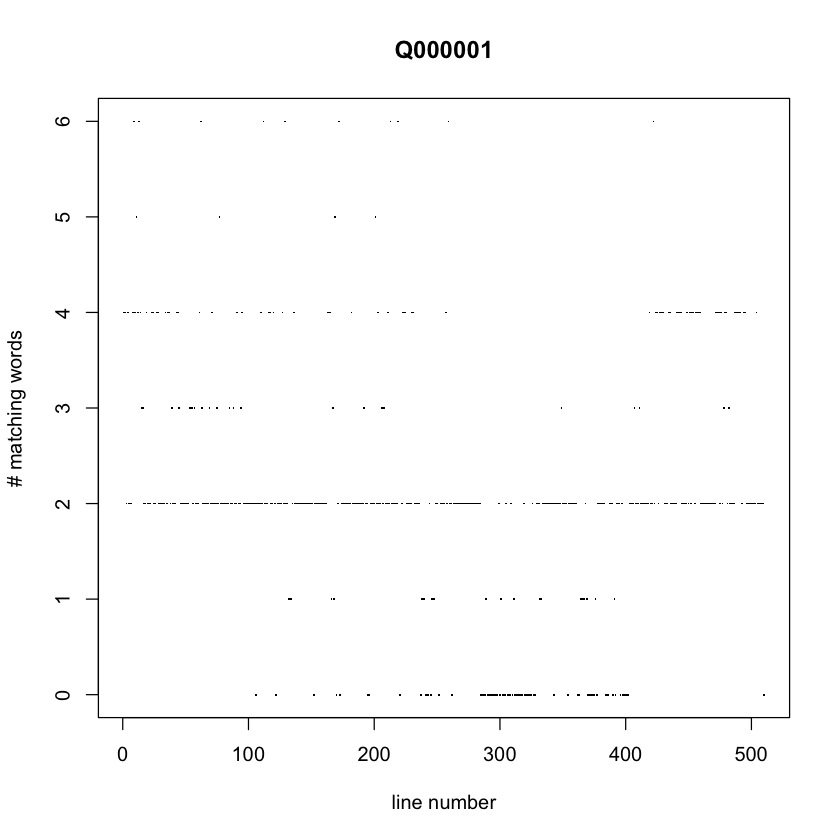

Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement lengt

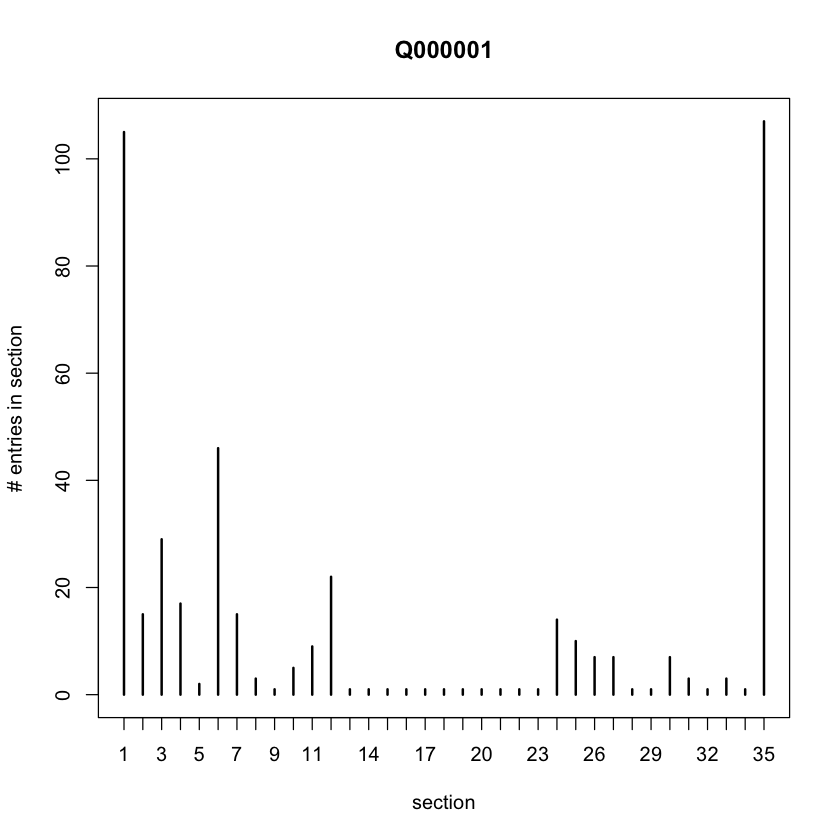

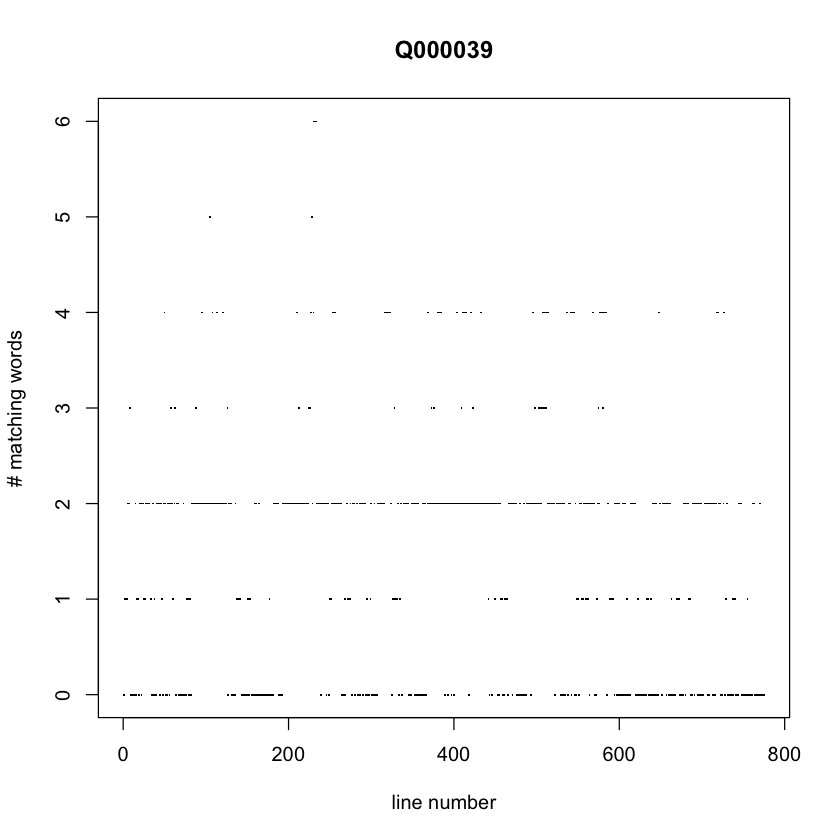

Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement lengt

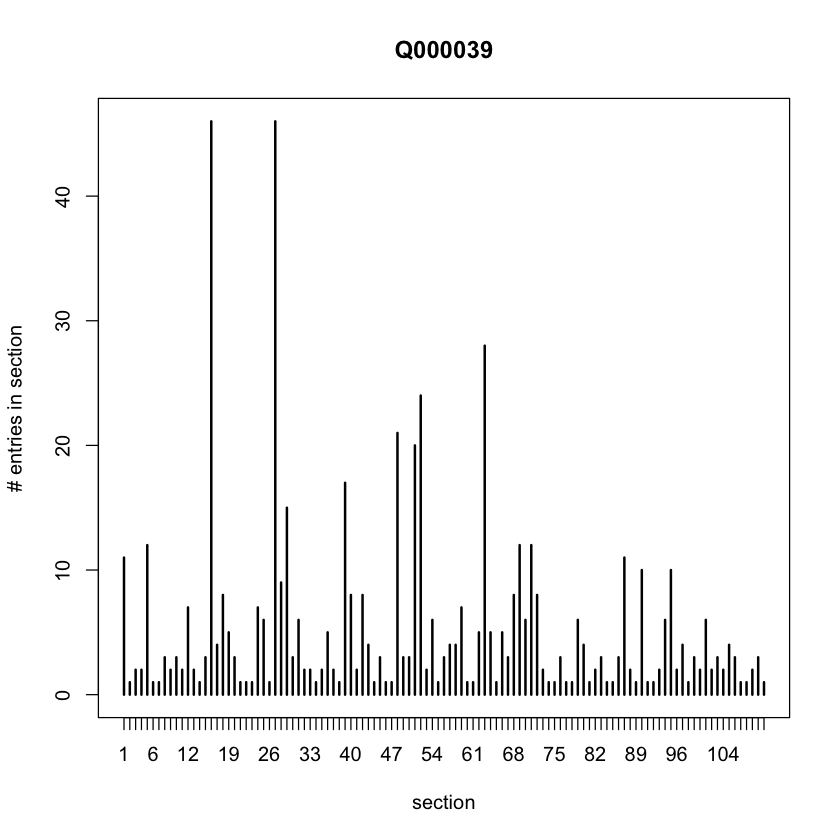

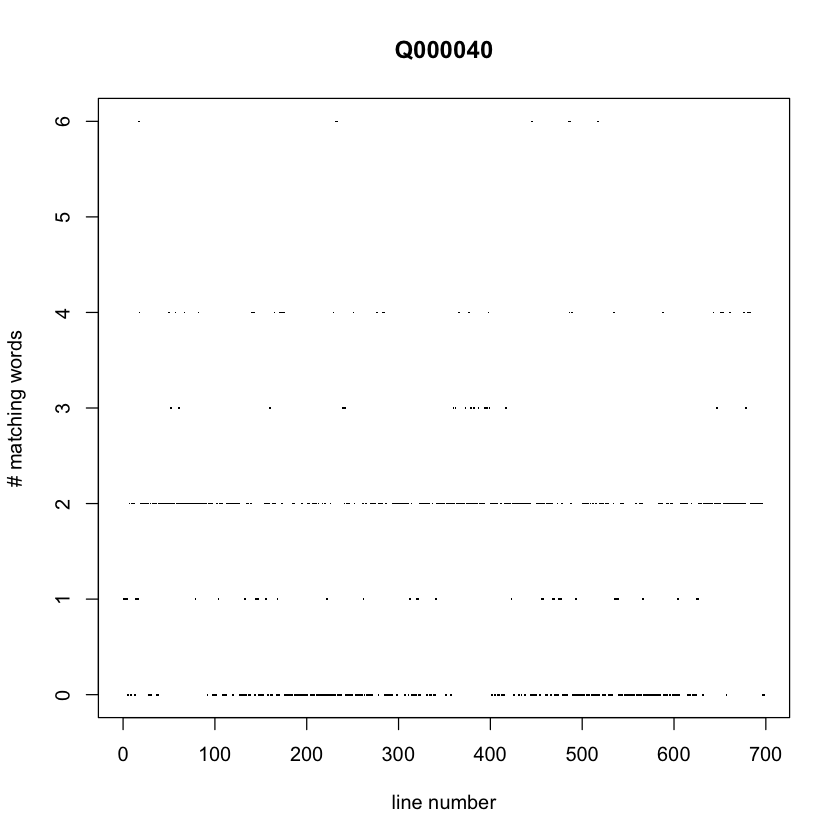

Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement lengt

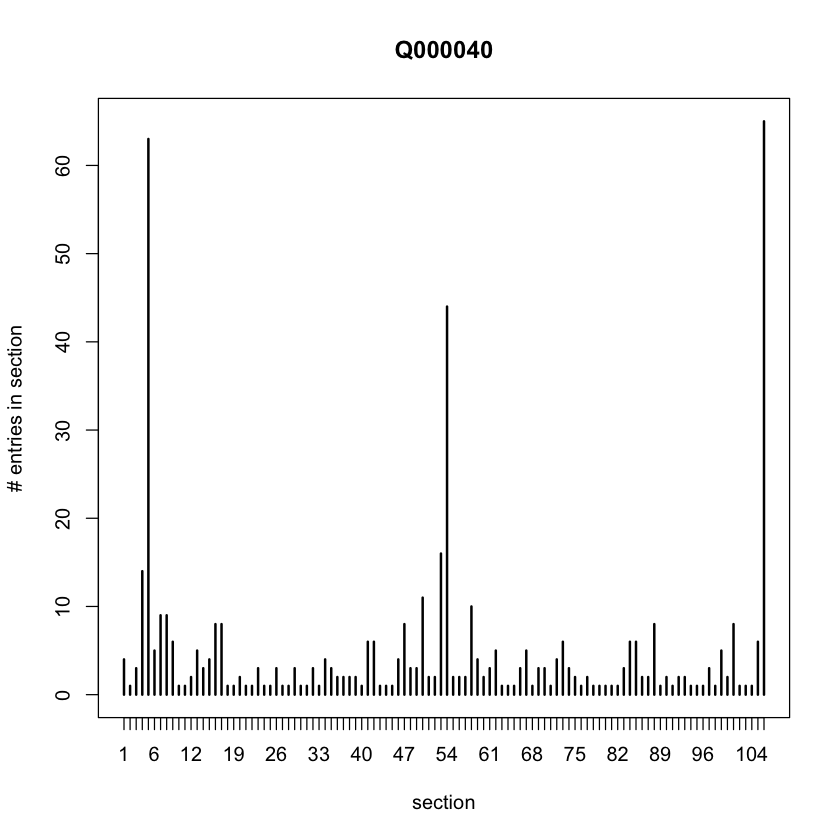

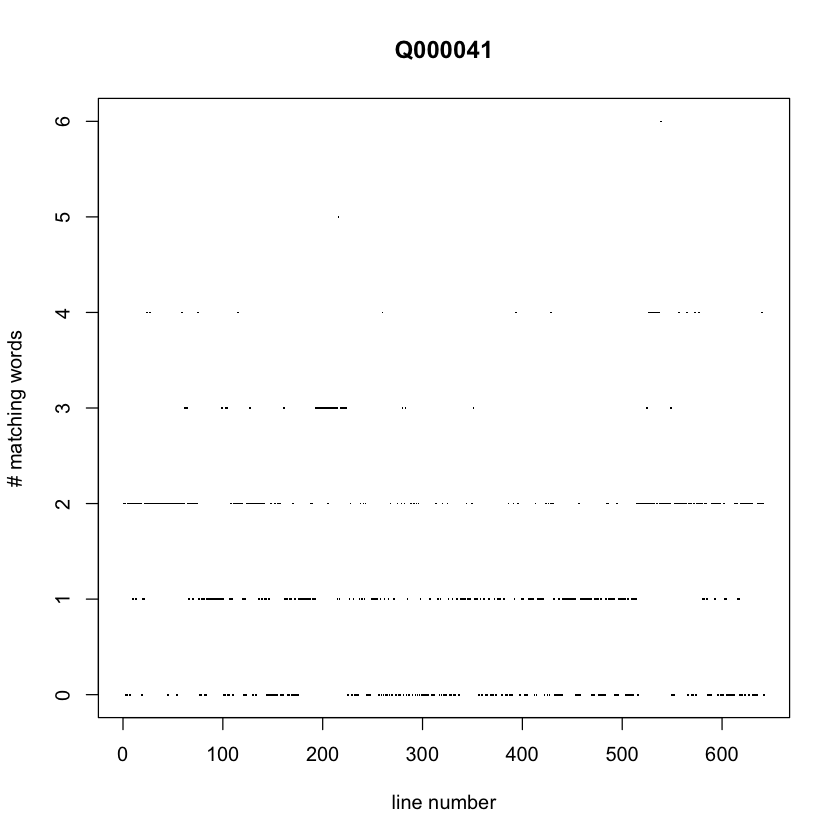

Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$k[i] = k:
“number of items to replace is not a multiple of replacement length”Warning message in df_compare$kmer[i] = kmer:
“number of items to replace is not a multiple of replacement lengt

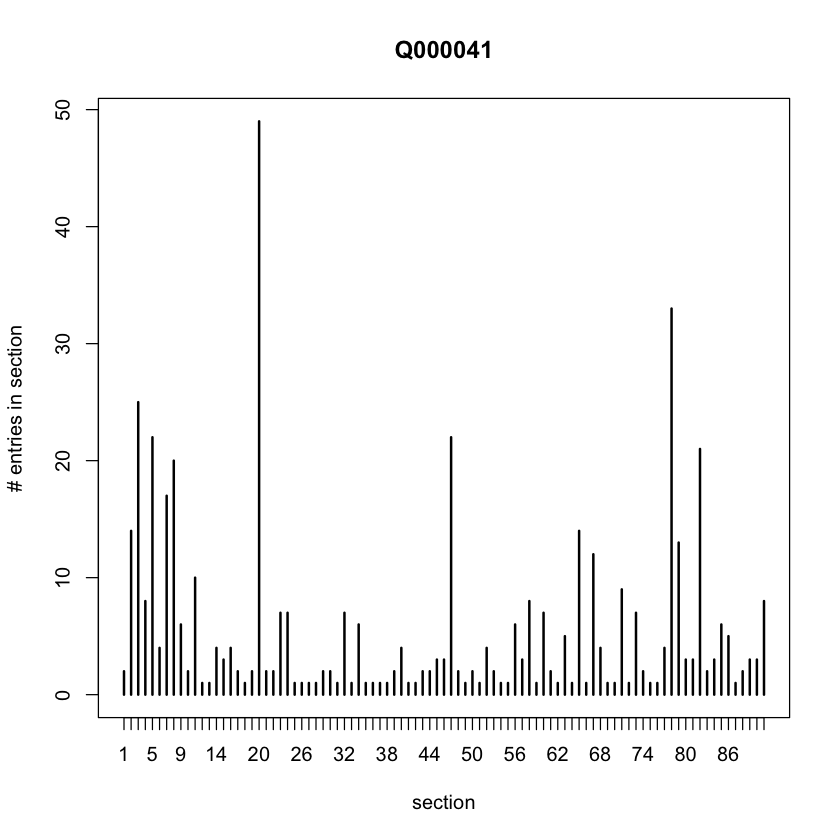

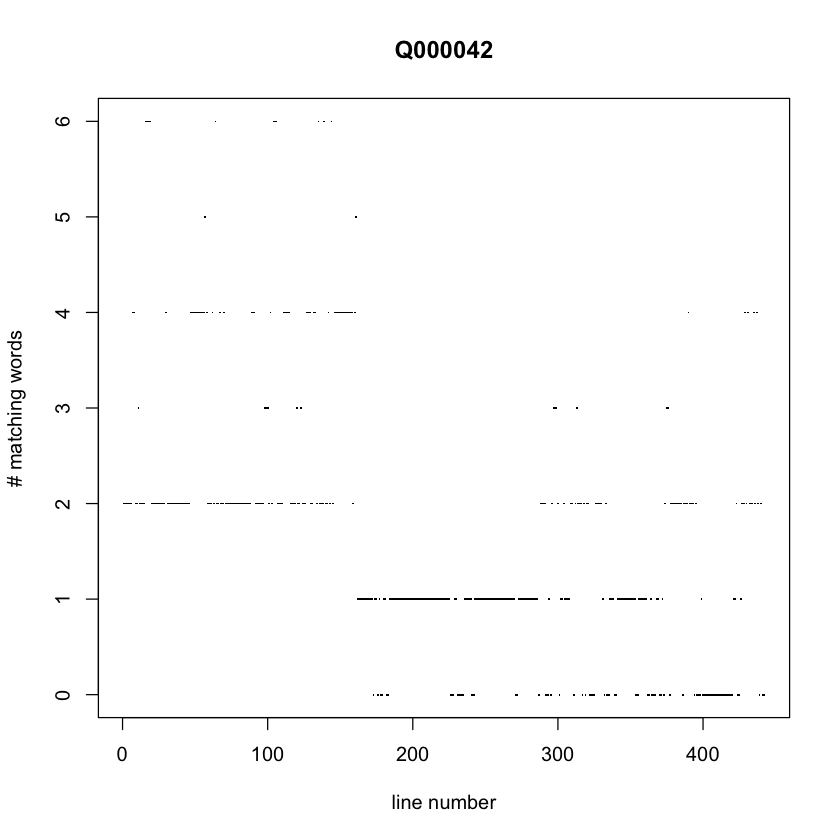

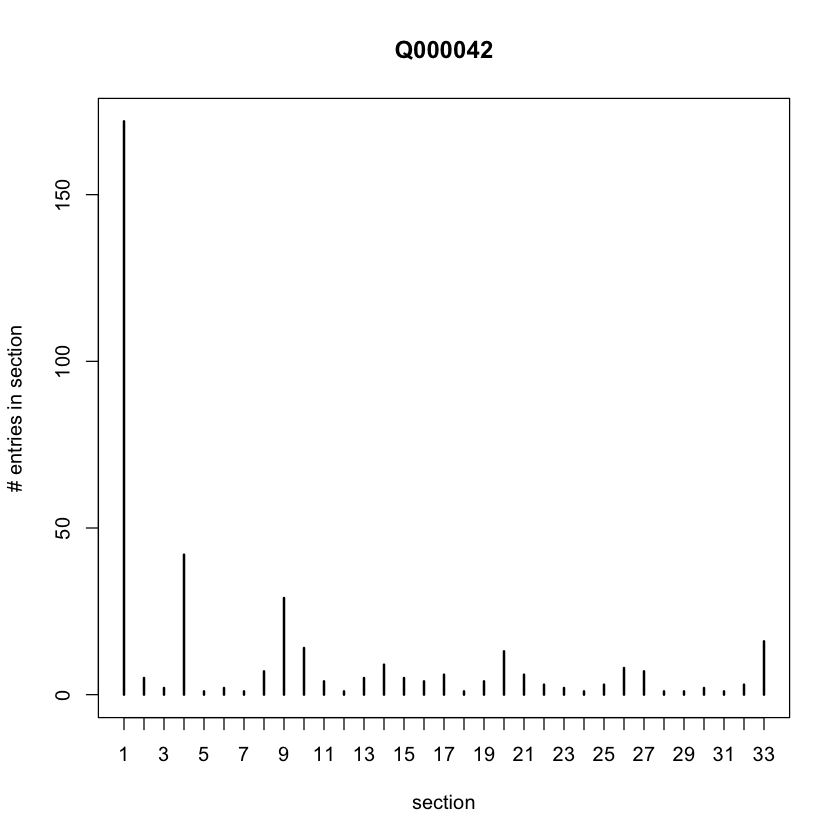

In [10]:
setwd("../data/composite_texts/")

Q1 = compare_entries("Q000001.csv", cutoff = 3, "Q000001_sections.csv")
Q39 = compare_entries("Q000039.csv", cutoff = 3, "Q000039_sections.csv")
Q40 = compare_entries("Q000040.csv", cutoff = 3, "Q000040_sections.csv")
Q41 = compare_entries("Q000041.csv", cutoff = 3, "Q000041_sections.csv")
Q42 = compare_entries("Q000042.csv", cutoff = 3, "Q000042_sections.csv")

In [11]:
####### Read in section definitions from file #######

Q1_sections = read.csv("Q000001_sections.csv", stringsAsFactors = FALSE)
Q39_sections = read.csv("Q000039_sections.csv", stringsAsFactors = FALSE)
Q40_sections = read.csv("Q000040_sections.csv", stringsAsFactors = FALSE)
Q41_sections = read.csv("Q000040_sections.csv", stringsAsFactors = FALSE)
Q42_sections = read.csv("Q000042_sections.csv", stringsAsFactors = FALSE)

# Map sections to documents

For each document in a corpus, determine whether each section represented in the reference text is present in that document. For each section, determine how many times an entry from that section is present in each document.

In [8]:
map_sections = function(corpus_file, section_defs) {
# Read in a csv listing all documents in corpus with text IDs
    corpus = read.csv(corpus_file)
# make df to store results
    doc_list = unique(corpus$id_text)
    section_names = colnames(section_defs)
    section_df = data.frame(sapply(doc_list, function(x) 
        x = numeric(length(section_names))), row.names = section_names)
    colnames(section_df) = doc_list
    doc_list = as.character(doc_list)
        
# iterate through sections and documents to populate df counts
    for (j in unique(doc_list)) {
        entries = as.character(corpus[which(corpus$id_text == j),]$entry)
        for (i in 1:ncol(section_defs)) {
            presence = sum(section_defs[,i] %in% tolower(entries))
            # if (presence > 0) presence = 1
            section_df[i, j] = presence 
            }
      section_df
    }
section_df
}


In [9]:
test = map_sections("../pass/Q39_par.csv", Q39_sections)
head(test)

,P117395,P117404,P128345,P224980,P224986,P224994,P224996,P225006,P225023,P225033,⋯,P459224,P459225,P459226,P459227,P459228,P459230,P459231,P459784,P492330,Q000039
tree,0,0,0,0,0,0,0,0,0,0,⋯,0,0,6,0,0,0,0,0,0,12
apple,0,0,0,0,0,0,0,0,0,0,⋯,0,0,2,0,0,0,0,0,0,2
tree.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,3,0,3
tamarisk,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
tree.2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,13
plum,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2


In [10]:
test2 = map_sections("../pass/Q01_par.csv", Q1_sections)
test2$section_name = row.names(test2)
test2$section_name = NULL
colSums(test2)

P225009 P235800 P247526 P247533 P247541 P247545 P249377 P249381 P253246 P253879 
      3       3      30      11       3       0       1       2       9       3 
P253902 P254359 P272557 P388082 Q000001 
      1       1       1       1     450

In [ ]:
melted_df = melt(test)
head(melted_df)

In [ ]:
melted_df_binary = melted_df
for (i in 1:nrow(melted_df_binary)) {
  if (melted_df_binary$value[i] > 0) melted_df_binary$value[i] = 1
}

head(melted_df_binary)

# Make heatmaps

In [ ]:
ggplot(data = melted_df, aes(y = variable, x = section_name)) +
  geom_tile(aes(fill = value)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 3), axis.text.y = element_text(size = 3))

qplot(data = melted_df_binary, x = section_name, y = variable, fill = factor(value),
   geom = "tile") + scale_fill_manual(values = c("0"="lightblue", "1" = "red")) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 3), axis.text.y = element_text(size = 3))
